**A/B-ТЕСТИРОВАНИЕ**

**Описание проекта**

Задача — провести оценку результатов A/B-теста.

Техническое задание:

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**Оглавление:**


[Шаг 1. Загрузка данных](#step_1)

[Шаг 2. Исследовательский анализ данных](#step_2)

[Шаг 3. Анализ воронки событий](#step_3)

[Шаг 4. Распределение событий на пользователя](#step_4)

[Шаг 5. Распределение активности по дням](#step_5)

[Шаг 6. Анализ эксперемента](#step_6)

[Шаг 7. Общий вывод](#step_5)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

import math as mth
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150  

<a id='step_1'></a>
**Шаг №1. Загрузим данные**

In [3]:
events = pd.read_csv('ab_project_marketing_events.csv') 
new_users = pd.read_csv('final_ab_new_users.csv') 
final_ab_events = pd.read_csv('final_ab_events.csv') 
final_ab_participants= pd.read_csv('final_ab_participants.csv') 

In [4]:
"""
#от ревьюера
try:
    events = pd.read_csv('ab_project_marketing_events.csv') 
    new_users = pd.read_csv('final_ab_new_users.csv') 
    final_ab_events = pd.read_csv('final_ab_events.csv') 
    final_ab_participants= pd.read_csv('final_ab_participants.csv') 
except:
    events = pd.read_csv('/datasets/ab_project_marketing_events.csv') 
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv') 
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv') 
    final_ab_participants= pd.read_csv('/datasets/final_ab_participants.csv') 
"""

"\n#от ревьюера\ntry:\n    events = pd.read_csv('ab_project_marketing_events.csv') \n    new_users = pd.read_csv('final_ab_new_users.csv') \n    final_ab_events = pd.read_csv('final_ab_events.csv') \n    final_ab_participants= pd.read_csv('final_ab_participants.csv') \nexcept:\n    events = pd.read_csv('/datasets/ab_project_marketing_events.csv') \n    new_users = pd.read_csv('/datasets/final_ab_new_users.csv') \n    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv') \n    final_ab_participants= pd.read_csv('/datasets/final_ab_participants.csv') \n"

In [5]:
display(events.info(), events.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [6]:
# поменяем тип данных для начала и конца периода акции
events['start_dt'] = pd.to_datetime(events['start_dt'], format='%Y-%m-%d')
events['finish_dt'] = pd.to_datetime(events['finish_dt'], format='%Y-%m-%d')

In [7]:
display(new_users.info(), new_users.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
4594,9C815B8DDBFBA8C0,2020-12-07,EU,PC
35026,33A2EBA4B650660C,2020-12-10,EU,Android
1590,85F83388A8217893,2020-12-07,EU,Android
55411,DED8C9D0468258AF,2020-12-13,EU,Android
57990,436F7316FC6F0B83,2020-12-20,N.America,Mac


In [8]:
# поменяем тип данных для даты
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')

In [9]:
print('Данные по новым пользователям за период {:%d-%m-%Y} - {:%d-%m-%Y}'.format(new_users['first_date'].min(), new_users['first_date'].max()))

Данные по новым пользователям за период 07-12-2020 - 23-12-2020


In [10]:
# посмотрим на пользователей за 22 и 23.12, так как по тех заданию новые пользователи считаются до 21.12.
print('Всего {} новых пользователей, зарегестрированных после 21.12.2020'.format(new_users.query('first_date > "2020-12-21"').shape[0]))

Всего 5263 новых пользователей, зарегестрированных после 21.12.2020


In [11]:
# посмотрим на уникальные значения для регионов, девайсов и дубликаты как для строк, так и для user_id
new_users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

In [12]:
new_users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

In [13]:
print(new_users.duplicated().sum())
print(new_users['user_id'].duplicated().sum())

0
0


In [14]:
display(final_ab_events.info(), final_ab_events.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
70331,3CA66EE8AC1A8AEE,2020-12-11 00:15:51,product_cart,NaN
172691,76D68D8E41A2F3BC,2020-12-16 01:12:13,product_page,NaN
365623,78A9C266CE052621,2020-12-20 08:36:42,login,NaN
143343,6B46909667E18A3B,2020-12-11 02:38:05,product_page,NaN
337396,CB721FD211C45C05,2020-12-18 20:18:07,login,NaN


In [15]:
# поменяем тип данных для даты
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format='%Y-%m-%d')

In [16]:
print('Данные по логам за период {:%d-%m-%Y} - {:%d-%m-%Y}'.format(final_ab_events['event_dt'].min(),final_ab_events['event_dt'].max()))

Данные по логам за период 07-12-2020 - 30-12-2020


In [17]:
# посмотрим на пустые значения
final_ab_events.groupby('event_name')['details'].value_counts()

event_name  details
purchase    4.99       46362
            9.99        9530
            99.99       5631
            499.99      1217
Name: details, dtype: int64

In [18]:
final_ab_events.query('event_name == "purchase"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62740 entries, 0 to 62739
Data columns (total 4 columns):
user_id       62740 non-null object
event_dt      62740 non-null datetime64[ns]
event_name    62740 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.4+ MB


Поле details заполнено только для событие покупка, для других событий поле details не заполенено, так как, видимо, записывается сумма покупки в у.е.

In [19]:
# проверим на дубликаты 
final_ab_events.duplicated().sum()

0

In [20]:
display(final_ab_participants.info(), final_ab_participants.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
16817,59F13CB8BB6D3A55,B,interface_eu_test
10259,81EF6E82B9F78D45,B,interface_eu_test
11686,668808B6EEAD19AD,B,interface_eu_test
17551,19100CE2C73D9BA0,B,interface_eu_test
12640,256961F615E4E515,B,interface_eu_test


In [21]:
# проверим на дубликат 
final_ab_participants.duplicated().sum()

0

In [22]:
final_ab_participants.groupby('ab_test')['group'].value_counts().unstack()

group,A,B
ab_test,,
interface_eu_test,5831,5736
recommender_system_test,3824,2877


В каждом дф привели дату к нужному типу, явных дуликатов нет, пропуски есть в данных о логах, но они соответсвуют логике: для события типа покупка в поле details записывается сумма покупки. 

Дф с новыми пользователемя содержит пользователей до 23.12.2020, а по тех. заданию новыми считаются пользователи до 21.12.20. Данные о логах содержат данные до 30.12.2020, когда как по тех. заданию данные должны быть до 04.01.2021. Так же в данных данные о двух тестах.

<a id='step_2'></a>
**Шаг №2. Исследовательский анализ данных**

In [23]:
# так как новые пользователи считаются до 21.12.2020, выделим id нужных нам пользователей 
new_users_2112 = new_users.query('first_date <= "2020-12-21"')

In [24]:
# посмотрим, сколько пользователей участвовали в обоих тестах
print("Всего уникальных пользователей", final_ab_participants.user_id.nunique())
print("Их них {} или {:.2%} участвовали в тесте interface_eu_test".format(final_ab_participants.query('ab_test == "interface_eu_test"')['user_id'].nunique(), final_ab_participants.query('ab_test == "interface_eu_test"')['user_id'].nunique()/final_ab_participants.user_id.nunique()))
print("Их них {} или {:.2%} участвовали в тесте recommender_system_test".format(final_ab_participants.query('ab_test == "recommender_system_test"')['user_id'].nunique(), final_ab_participants.query('ab_test == "recommender_system_test"')['user_id'].nunique()/ final_ab_participants.user_id.nunique()))
print('При этом {} или {:.2%} участвовали в обоих тестах'.format(final_ab_participants['user_id'].duplicated().sum(), final_ab_participants['user_id'].duplicated().sum()/final_ab_participants.user_id.nunique()))

Всего уникальных пользователей 16666
Их них 11567 или 69.40% участвовали в тесте interface_eu_test
Их них 6701 или 40.21% участвовали в тесте recommender_system_test
При этом 1602 или 9.61% участвовали в обоих тестах


In [25]:
#testB_users = final_ab_participants.query('ab_test == "interface_eu_test"')['user_id'].to_list()
#testA_users = final_ab_participants.query('ab_test == "recommender_system_test"')['user_id'].to_list()
#len(pd.Series(np.intersect1d(testA_users, testB_users)))

In [26]:
# создадит список пользователей с нужным тестом и проверим, чтобы пользователи входили только в одну группу
final_ab_participants_testA = final_ab_participants.query('ab_test == "recommender_system_test"')
final_ab_participants_testA['user_id'].duplicated().sum()


0

In [27]:
# посмотрим, есть ли там пользователи, регестрированные до 21.12 и после 22.12
usersNEW = new_users.query('first_date > "2020-12-21"')['user_id'].unique()
usersALL = final_ab_participants_testA['user_id'].unique()
print('Всего {} пользователей, зарегестрированных после 21.12, примали участие в тесте recommender_system_test'.format(len(pd.Series(np.intersect1d(usersNEW, usersALL)))))

Всего 0 пользователей, зарегестрированных после 21.12, примали участие в тесте recommender_system_test


In [28]:
# по тех. заданию 15% должны быть из региона EU. проверим, так ли это 
final_ab_participants_testA_region = final_ab_participants_testA.merge(new_users, on = 'user_id', how = 'left').groupby('region')['user_id'].count().to_frame()
final_ab_participants_testA_region['%'] = (100* final_ab_participants_testA_region/final_ab_participants_testA_region.sum()).round(2)
final_ab_participants_testA_region

,user_id,%
region,,
APAC,72,1.07
CIS,55,0.82
EU,6351,94.78
N.America,223,3.33


In [29]:
final_ab_participants_testA['user_id'].nunique()

6701

94% пользователей их региона EU, основная масса. 

In [30]:
# теперь выделим логи по пользователям, которые участвовали в нужном нам тесте
final_ab_testA = final_ab_events.merge(final_ab_participants_testA, on = 'user_id', how = 'right')
final_ab_testA.sample(5)

,user_id,event_dt,event_name,details,group,ab_test
13487,AC8A411A22EAA8D8,2020-12-18 13:34:30,login,NaN,A,recommender_system_test
6367,50319767BCBD5646,2020-12-21 14:46:57,login,NaN,A,recommender_system_test
18345,2977FB7014B7AAFD,2020-12-17 23:20:54,login,NaN,A,recommender_system_test
1723,52EEF8198C6E61BF,2020-12-10 22:17:23,product_cart,NaN,B,recommender_system_test
7955,F1DBF417227551E7,2020-12-20 12:22:50,login,NaN,B,recommender_system_test


In [31]:
# посмотрим на пропуски 
final_ab_testA.isnull().sum()

user_id           0
event_dt       3026
event_name     3026
details       24393
group             0
ab_test           0
dtype: int64

У 3026 пользователей, которые принимали участие в эксперементе, нет логов.

In [32]:
# удалим пустые строки и посмотрим распределение пользователей по группам 
mask = final_ab_testA['event_dt'].isna()
index = final_ab_testA[mask].index
final_ab_testA = final_ab_testA.drop(index = index)
final_ab_testA.groupby('group')['user_id'].nunique()

group
A    2747
B     928
Name: user_id, dtype: int64

In [33]:
print('Данные по логам для теста recommender_system_test за период {:%d-%m-%Y} - {:%d-%m-%Y}'.format(final_ab_testA['event_dt'].min(),final_ab_testA['event_dt'].max()))

Данные по логам для теста recommender_system_test за период 07-12-2020 - 30-12-2020


In [34]:
#посмотрим, какие еще маркетинговые активность проводились в это время 
events.query('(finish_dt >= "2020-12-07") and (start_dt <= "2020-12-30")')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [35]:
# оставим только те логи, которые были совершены за 14 дней после дня регестрации каждого пользователя
final_ab_testA = final_ab_testA.merge(new_users, on = 'user_id', how = 'inner')
#final_ab_testA['first_date'] = pd.to_datetime(final_ab_testA['first_date'], format='%Y-%m-%d')

In [36]:
final_ab_testA['first_date'] = pd.to_datetime(final_ab_testA['first_date'], format='%Y-%m-%d')

In [37]:
final_ab_testA['days_from_reg'] = final_ab_testA['event_dt'] - final_ab_testA['first_date']
final_ab_testA['days_from_reg'] = (final_ab_testA['days_from_reg'] / np.timedelta64(1, 'D')).round().astype('int')
final_ab_testA.head()


,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,days_from_reg
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,0
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test,2020-12-07,EU,Android,2
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,0
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,1
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,2


In [38]:
# удалим события, которые были сделала 14 и более дней после регестарции
final_ab_testA.query('days_from_reg >= 14').index
final_ab_testA = final_ab_testA.drop(index = final_ab_testA.query('days_from_reg >= 14').index)

В данных сведения о участниках двух тестов, при это 1602 или 9.61% участвовали в обоих тестах.
Для теста recommender_system_test группы составлены корректрно: пользователь участвует только в одной группе. 

В анализируемом тесте принимали участие 6701 новых пользователей, что соответсвует тех. заданию. 
При этом 94% из региона EU, что не соответсвует тех. заданию, по которому 15% пользователей должны быть из региона EU.
Пересечений пользователей по группам нет. 

Тем не менее у 3026 пользователей нет данных о событий, они не пользовались ресурсом. 

Данные о логах не полные, они предоставлены за период 07-12-2020 - 30-12-2020, когда как по тех заданию тест должны были остановить 04-01-2021. 

Так же в данный период проводились макретинговые акции: Christmas&New Year Promo с 25.12.2020 по 03.01.2021 и CIS New Year Gift Lottery	началась как раз 30.12.2020.  

Итого группы распределены не равномерно: активных пользователей в группе А больше пользователей в группе В более чем в 2,5 раз, временной период, требование к аудитории и ожидаемое количество участников теста не соответвует тех. заданию. Поэтому тест не возможен. 

<a id='step_3'></a>
**Шаг №3. Анализ воронки продаж**

In [39]:
# посмотрим на виды событий
final_ab_testA.groupby('event_name')['event_name'].count().sort_values(ascending = False)

event_name
login           10737
product_page     6652
purchase         3218
product_cart     3128
Name: event_name, dtype: int64

In [40]:
# посмотрим для каждого события количество уникальных пользователей и посчитаем их долю
data_events = final_ab_testA.groupby('event_name').agg({'user_id' : 'nunique'}).reset_index().rename(columns = {"user_id":'unique_users'})
data_events['conv'] = 100 *data_events['unique_users']/len(final_ab_testA['user_id'].unique())
data_events.sort_values(by = 'unique_users', ascending = False)

,event_name,unique_users,conv
0,login,3674,99.972789
2,product_page,2303,62.666667
3,purchase,1128,30.693878
1,product_cart,1079,29.360544


События можно трактовать как войти-страница продукта-корзина-покупка. При этом количество событий покупка больше чем корзина. Видимо, покупка возможна минуя корзину, к прирмеру, быстрый оплата со страницы товара.

In [41]:
# доавим последовательность событий
data_events['step'] = [0, 2, 1, 3]
data_events = data_events.sort_values(by ='step').reset_index(drop = True)
data_events = data_events.drop(columns = 'step')
data_events

,event_name,unique_users,conv
0,login,3674,99.972789
1,product_page,2303,62.666667
2,product_cart,1079,29.360544
3,purchase,1128,30.693878


In [42]:
data_events.loc[0, 'conv_next_step'] = 100
for x in range(1, data_events.shape[0]):
    data_events.loc[x, 'conv_next_step'] = 100 * data_events.loc[x, 'unique_users'] / data_events.loc[x-1, 'unique_users']

In [43]:
data_events

,event_name,unique_users,conv,conv_next_step
0,login,3674,99.972789,100.000000
1,product_page,2303,62.666667,62.683723
2,product_cart,1079,29.360544,46.851932
3,purchase,1128,30.693878,104.541242


In [44]:
# посмотрим, сколько % переходят со страницы продукта на оплату
print(' {:.2%} пользователей доходят до оплата со страницы продукта'.format( data_events.loc[3, 'unique_users'] / data_events.loc[1, 'unique_users']))

 48.98% пользователей доходят до оплата со страницы продукта


На страницу продукта переходят 62,6% всех пользователей, из них 46,8% переходят в корзину, а 48,98% из них доходят до оплаты. Достаточно хорошая конверсия, даже высокая. 

In [45]:
# получим сводную таблицу с количеством уникальных пользователей по каждому событию в разбивке по группам и посмотрим на воронки тут
data_events_groups = final_ab_testA.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique').reset_index()
data_events_groups['step'] = [0, 2, 1, 3]
data_events_groups = data_events_groups.sort_values(by ='step').reset_index(drop = True).drop(columns = 'step')
data_events_groups

group,event_name,A,B
0,login,2747,927
1,product_page,1780,523
2,product_cart,824,255
3,purchase,872,256


In [46]:
data_events_groups.loc[0, 'conv_next_step_A'] = 100
data_events_groups.loc[0, 'conv_next_step_B'] = 100
for x in range(1, data_events.shape[0]):
    data_events_groups.loc[x, 'conv_next_step_A'] = 100 * data_events_groups.loc[x, 'A'] / data_events_groups.loc[x-1, 'A']
    data_events_groups.loc[x, 'conv_next_step_B'] = 100 * data_events_groups.loc[x, 'B'] / data_events_groups.loc[x-1, 'B']

In [47]:
data_events_groups

group,event_name,A,B,conv_next_step_A,conv_next_step_B
0,login,2747,927,100.000000,100.000000
1,product_page,1780,523,64.797961,56.418554
2,product_cart,824,255,46.292135,48.757170
3,purchase,872,256,105.825243,100.392157


In [48]:
print(' {:.2%} пользователей доходят до оплаты со страницы продукта для группы А'.format(data_events_groups.loc[3, 'A'] / data_events_groups.loc[1, 'A']))
print(' {:.2%} пользователей доходят до оплаты со страницы продукта для группы В'.format(data_events_groups.loc[3, 'B'] / data_events_groups.loc[1, 'B']))

 48.99% пользователей доходят до оплаты со страницы продукта для группы А
 48.95% пользователей доходят до оплаты со страницы продукта для группы В


В целом группы равнозначны: в каждой группе 49% пользователей, зашедших на страницу товара, оплачивают товар. Тем не менее группа А лучше ведет себя при переходе на страницу товара: здесь конверсия группы А выше практически на 9% по сравнению с группы В. Явных улучшений для группе В нет. 

<a id='step_4'></a>
**Шаг №4. Распределение событий на пользователя**

In [49]:
# посмотрим на количество событий на пользователя для каждой выборки
events_testA = final_ab_testA.groupby('group').agg({'user_id': 'nunique', 'event_name':'count'}).reset_index()
events_testA['event_per_user'] = events_testA['event_name'] / events_testA['user_id']
events_testA.columns = ['group', 'unique_users', 'total_events', 'event_per_user']
events_testA

,group,unique_users,total_events,event_per_user
0,A,2747,18705,6.809246
1,B,928,5030,5.420259


Пользователи группы А активнее группы В: в группе А на пользователя приходится по 7 событий, когда как в группе В по 5.8 событий на пользователя. 

<a id='step_5'></a>
**Шаг №5. Распределение активности по дням**

In [50]:
# посмотрим на активность по времени
final_ab_testA['date'] = final_ab_testA['event_dt'].dt.date
final_ab_testA['hour'] = final_ab_testA['event_dt'].dt.hour

In [51]:
#final_ab_testA = final_ab_testA.merge(new_users, on = 'user_id', how = 'inner')
#final_ab_testA['first_date'] = final_ab_testA['first_date'].dt.date

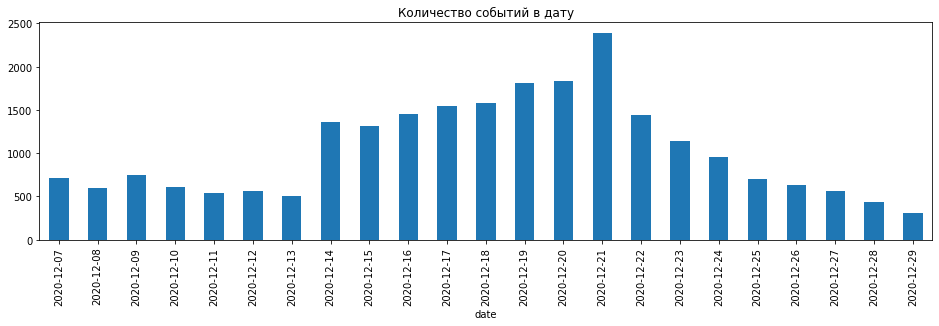

In [52]:
plt.title('Количество событий в дату')
final_ab_testA.groupby('date')['date'].count().plot(kind = 'bar', figsize = (16, 4));

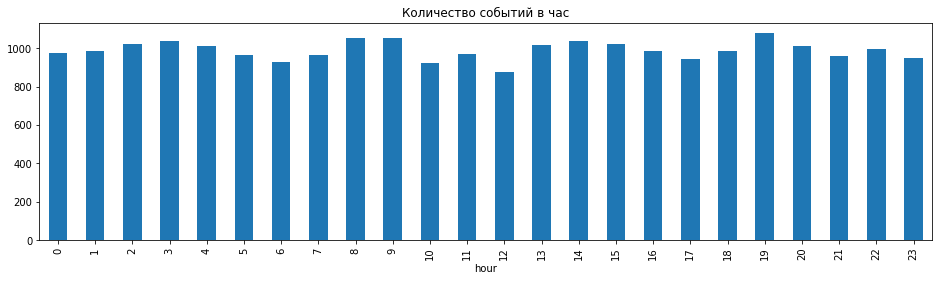

In [53]:
plt.title('Количество событий в час')
final_ab_testA.groupby('hour')['hour'].count().plot(kind = 'bar', figsize = (16, 4));

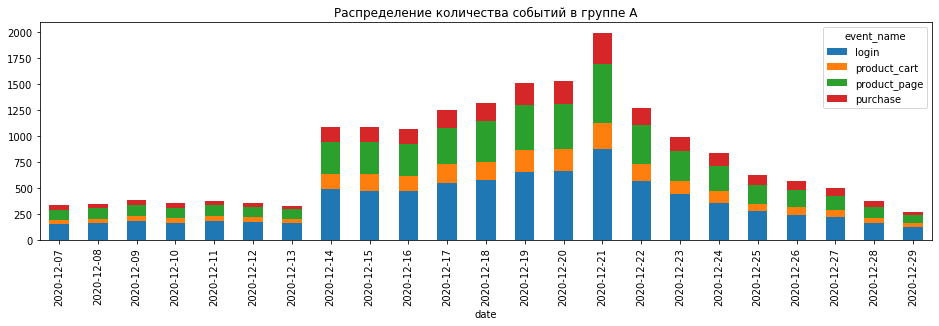

In [54]:
#посмотрим по группам 
final_ab_testA.query('group == "A"').pivot_table(index='date', values='user_id',columns='event_name',aggfunc='count').plot(kind = 'bar', stacked = True, figsize=(16,4))
plt.title("Распределение количества событий в группе A")
plt.show()

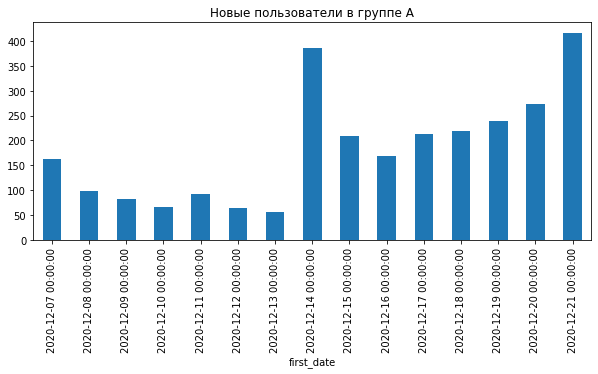

In [55]:
final_ab_testA.query('group == "A"')[['user_id', 'first_date']].drop_duplicates().groupby('first_date')['user_id'].count().plot(kind ='bar', figsize = (10, 4))
plt.title("Новые пользователи в группе A");

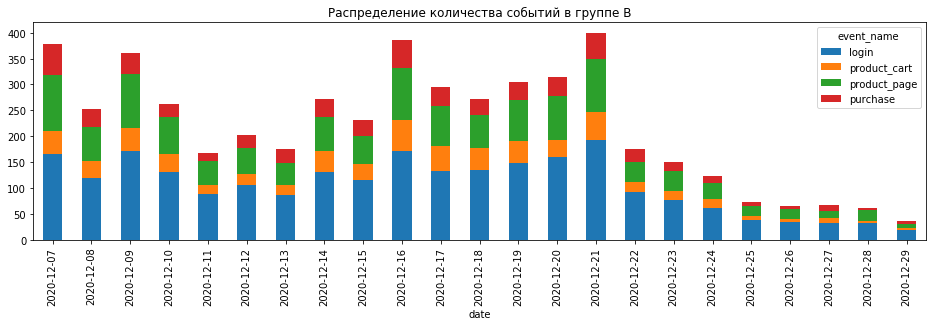

In [56]:
final_ab_testA.query('group == "B"').pivot_table(index='date', values='user_id',columns='event_name',aggfunc='count').plot(kind = 'bar', stacked = True, figsize=(16,4))
plt.title("Распределение количества событий в группе B")
plt.show()

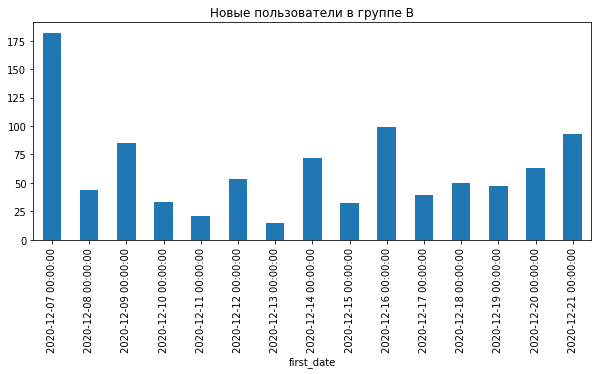

In [57]:
final_ab_testA.query('group == "B"')[['user_id', 'first_date']].drop_duplicates().groupby('first_date')['user_id'].count().plot(kind ='bar', figsize = (10, 4))
plt.title("Новые пользователи в группе B");

Пользователи в группах ведут себя по-разному во времени, но в целом это связано с притоком новых пользователей: активность дня зависит от количества привлеченных новых пользователей в день. 

<a id='step_6'></a>
**Шаг №4. Анализ результата эксперемента**

In [58]:
#добавим total
data_events_groups['total_A'] = data_events_groups.loc[0, 'A']
data_events_groups['total_B'] = data_events_groups.loc[0, 'B']
data_events_groups

group,event_name,A,B,conv_next_step_A,conv_next_step_B,total_A,total_B
0,login,2747,927,100.000000,100.000000,2747,927
1,product_page,1780,523,64.797961,56.418554,2747,927
2,product_cart,824,255,46.292135,48.757170,2747,927
3,purchase,872,256,105.825243,100.392157,2747,927


In [59]:
#проверим гипотезу о равенстве конверсии по каждому событию для двух генераньлых совокупностей
#нулевая гипотеза: конверсии (доли) для двух генеральных совокупностей равны
#альтернативная гипотеза: конверии (доли) для двух генеральных совокупностей не равны

def z_test(string):
    p1 = string['A'] / string['total_A']
    p2 = string['B']  / string['total_B']
    p_combined = (string['A'] + string['B']) / (string['total_A'] + string['total_B'])
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/string['total_A'] + 1/string['total_B']))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [68]:
def z_test_results(string):
    alpha = .05
    if string['p_value'] < alpha: 
        return 'Отвергаем нулевую гипотезу (конверсии не равны)'
    else:
        return 'Не получилось отвергнуть нулевую гипотезу'    

In [70]:
data_events_groups['p_value'] = data_events_groups.loc[1:3].apply(z_test, axis = 1)
data_events_groups['results_0.05'] = data_events_groups.loc[1:3].apply(z_test_results, axis = 1)
data_events_groups

group,event_name,A,B,conv_next_step_A,conv_next_step_B,total_A,total_B,p_value,results_0.05,results_0.017
0,login,2747,927,100.000000,100.000000,2747,927,NaN,NaN,NaN
1,product_page,1780,523,64.797961,56.418554,2747,927,0.000005,Отвергаем нулевую гипотезу (конверсии не равны),Отвергаем нулевую гипотезу (конверсии равны)
2,product_cart,824,255,46.292135,48.757170,2747,927,0.150342,Не получилось отвергнуть нулевую гипотезу,Не получилось отвергнуть нулевую гипотезу
3,purchase,872,256,105.825243,100.392157,2747,927,0.018475,Отвергаем нулевую гипотезу (конверсии не равны),Не получилось отвергнуть нулевую гипотезу


При уровне значимости 0.05 статистически разницы между коверсиями при переходе на страницу корзины нет, а между конверсиями при перехоже на страницы продукта и оплата есть.

Мы провели 3 теста, применим поправку Бонферрони, скорректируем уровень значимости на 0.05/3 = 0.017 и посмотрим на результаты.


In [64]:
def z_test_results_017(string):
    alpha = .017
    if string['p_value'] < alpha: 
        return 'Отвергаем нулевую гипотезу (конверсии не равны)'
    else:
        return 'Не получилось отвергнуть нулевую гипотезу'  

In [71]:
data_events_groups['results_0.017'] = data_events_groups.loc[1:3].apply(z_test_results_017, axis = 1)
data_events_groups

group,event_name,A,B,conv_next_step_A,conv_next_step_B,total_A,total_B,p_value,results_0.05,results_0.017
0,login,2747,927,100.000000,100.000000,2747,927,NaN,NaN,NaN
1,product_page,1780,523,64.797961,56.418554,2747,927,0.000005,Отвергаем нулевую гипотезу (конверсии не равны),Отвергаем нулевую гипотезу (конверсии равны)
2,product_cart,824,255,46.292135,48.757170,2747,927,0.150342,Не получилось отвергнуть нулевую гипотезу,Не получилось отвергнуть нулевую гипотезу
3,purchase,872,256,105.825243,100.392157,2747,927,0.018475,Отвергаем нулевую гипотезу (конверсии не равны),Не получилось отвергнуть нулевую гипотезу


При уровне значимости 0.017 статистически разница между коверсиями при переходе на странцу продукта есть, а между конверсиями при переходе на страницы корзина и покупка нет. 

<a id='step_7'></a>
**ОБЩИЙ ВЫВОД** 

В данных сведения о участниках двух тестов, при этом 1602 или 9.61% участвовали в обоих тестах.
Для теста recommender_system_test группы составлены корректрно: пользователь участвует только в одной группе. 

В анализируемом тесте принимали участие **6701 новых пользователей**, что соответсвует тех. заданию. 
При этом 94% из региона EU, что не соответсвует тех. заданию, по которому 15% пользователей должны быть из региона EU.
Пересечений пользователей по группам нет. 

Тем не менее у **3026 пользователей нет данных о событий**, они не пользовались ресурсом. 

**Данные о логах не полные**, они предоставлены за период 07-12-2020 - **30-12-2020**, когда как по тех заданию тест должны были остановить **04-01-2021**. 

Так же в период проведения теста проводились маркетинговые акции: Christmas&New Year Promo с 25.12.2020 по 03.01.2021 и CIS New Year Gift Lottery	началась как раз 30.12.2020. 

Итого **группы распределены не равномерно**: активных пользователей в группе А больше пользователей в группе В более чем в 2,5 раз, временной период, требование к аудитории и ожидаемое количество участников теста не соответвует тех. заданию. **Поэтому тест нельзя считать успешным.** 

События можно трактовать как **войти-страница продукта-корзина-покупка**. При этом **событий покупка больше чем корзина. Видимо, покупка возможна минуя корзину, к прирмеру, быстрый оплата со страницы товара.**

Пользователи группы А активнее группы В: в группе А на пользователя приходится по 7 событий, когда как в группе В по 5.8 событий на пользователя. Но ведут себя по-разному во времени, но в целом это связано с притоком новых пользователей: **активность дня зависит от количества привлеченных новых пользователей в день**.

На страницу продукта переходят 62,6% всех пользователей, из них 46,8% переходят в корзину, а 48,98% из них доходят до оплаты. 

По результатам z-теста при уровне значимости 0.05 группы ведут себя по-разному при переходе не страницу продукта и страницу оплата, а при уровне значимости 0.017 только при переходе на странцу продукта. **При этом группа А ведет себя лучше группе В при переходе на страницу продукта. Для конверсий при переходе на страницу корзина и оплата группы ведут себя равнозначно.**